# Logistic Regression

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

In [17]:
c1_x, c1_y = np.random.normal([1,1],[2,2], 100)
c1_x

array([0.66, 0.31, 0.39, 0.09, 0.79, 0.79, 0.98, 0.17, 0.44, 0.39, 0.56,
       0.24, 0.24, 0.29, 0.86, 0.96, 0.01, 0.84, 0.09, 0.78, 0.21, 0.47,
       0.21, 0.71, 0.14, 0.77, 0.88, 0.13, 0.97, 0.04, 0.33, 0.3 , 0.49,
       0.33, 0.08, 0.88, 0.29, 0.77, 0.2 , 0.47, 0.57, 0.72, 0.62, 0.62,
       0.49, 0.95, 0.98, 0.56, 0.88, 0.72, 0.6 , 0.99, 0.37, 0.43, 0.82,
       0.7 , 0.01, 0.88, 0.6 , 0.64, 0.93, 0.24, 0.2 , 0.75, 0.53, 0.91,
       0.88, 0.12, 0.07, 0.75, 0.88, 0.32, 0.5 , 0.54, 0.24, 0.66, 0.31,
       0.85, 0.43, 0.34, 0.37, 0.1 , 0.8 , 0.49, 0.9 , 0.92, 0.23, 0.99,
       0.24, 0.93, 0.74, 0.43, 0.94, 0.85, 0.43, 0.92, 0.58, 0.73, 0.7 ,
       0.5 ])

In [52]:
data_1 = np.random.normal([2.5,2.5],[1,1], [50,2])
data1_x = data_1[:,0]
data1_y = data_1[:,1]

data_2 = np.random.normal([4,4],[1,1], [50,2])
data2_x = data_2[:,0]
data2_y = data_2[:,1]

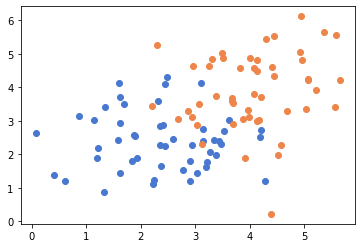

In [53]:
plt.scatter(data1_x, data1_y)
plt.scatter(data2_x, data2_y)

In [54]:
x_0 = np.concatenate([data1_x, data2_x])

In [55]:
y_0 = np.concatenate([np.zeros(50), np.ones(50)])
y_0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [56]:
with pm.Model() as model_0:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha + pm.math.dot(x_0, beta)
    #theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=theta, observed=y_0)

    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0 = pm.sample(5000, step, start)

/home/adegaray/Bayesian-Statistics/1st_assignment/BSPP/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8969660349846761, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6589375118850761, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/Bayesian-Statistics/1st_assignment/BSPP/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/tmp/ipykernel_3680/2971851116.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('binary_class_distribution_sampling.png', dpi=300, figsize=(5.5, 5.5))


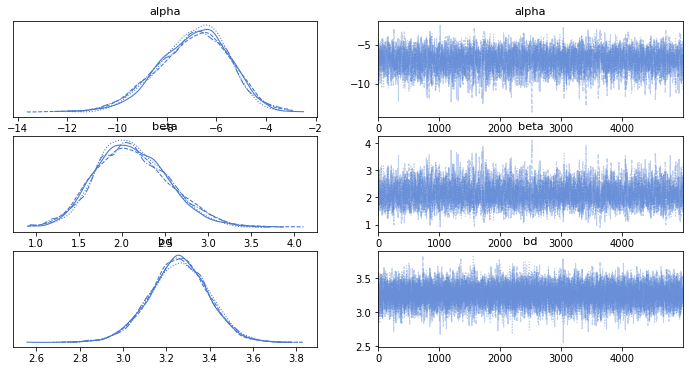

In [57]:
varnames = ['alpha', 'beta', 'bd']
pm.plot_trace(trace_0, varnames)
plt.savefig('binary_class_distribution_sampling.png', dpi=300, figsize=(5.5, 5.5))

In [48]:
#pm.autocorrplot(trace_0, varnames);

In [49]:
#sns.kdeplot(trace_0['alpha'], cadena_0['beta']);

In [58]:
pm.summary(trace_0, varnames)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/Bayesian-Statistics/1st_assignment/BSPP/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-6.94,1.43,-9.60,-4.32,2.60e-02,1.90e-02,2921.0,2302.0,1.0
beta,2.13,0.43,1.34,2.92,8.00e-03,6.00e-03,2920.0,2400.0,1.0
bd,3.26,0.14,3.00,3.51,1.00e-03,1.00e-03,14204.0,14012.0,1.0


/tmp/ipykernel_3680/2935434428.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  theta_hpd = pm.stats.hdi(trace_0['theta'])[idx]
/tmp/ipykernel_3680/2935434428.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('B04958_05_06.png', dpi=300, figsize=(5.5, 5.5))


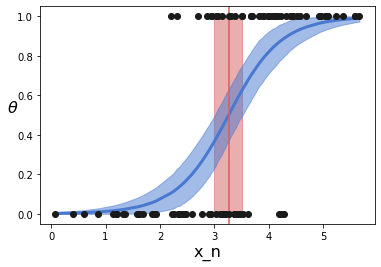

In [59]:
theta = trace_0['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_0['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.stats.hdi(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.stats.hdi(trace_0['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel('x_n', fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_05_06.png', dpi=300, figsize=(5.5, 5.5))

In [52]:
def classify(n, threshold):
    """
    A simple classifying function
    """
    n = np.array(n)
    mu = trace_0['alpha'].mean() + trace_0['beta'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob >= threshold

classify([5, 5.5, 6], 0.5)

(array([0.14, 0.59, 0.92]), array([False,  True,  True]))

## Multiple logistic regression

In [53]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] #['petal_length', 'petal_width'] 
x_1 = df[x_n].values

#x_1 = (x_1 - x_1.mean(axis=0))/x_1.std(axis=0) #
#x_1 = (x_1 - x_1.mean(axis=0))

In [54]:
with pm.Model() as model_1:
    # We define the prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_1, beta)
    # Aplly the logistic linking function
    theta = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    bd = pm.Deterministic('bd', -alpha/beta[1] - beta[0]/beta[1] * x_1[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=theta, observed=y_1)
    # Sampling
    #start = pm.find_MAP()
    #step = pm.NUTS()
    #trace_1 = pm.sample(5000, step, start)
    trace_1 = pm.sample(5000)

/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 28 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/tmp/ipykernel_9138/2951232963.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('B04958_05_07.png', dpi=300, figsize=(5.5, 5.5))


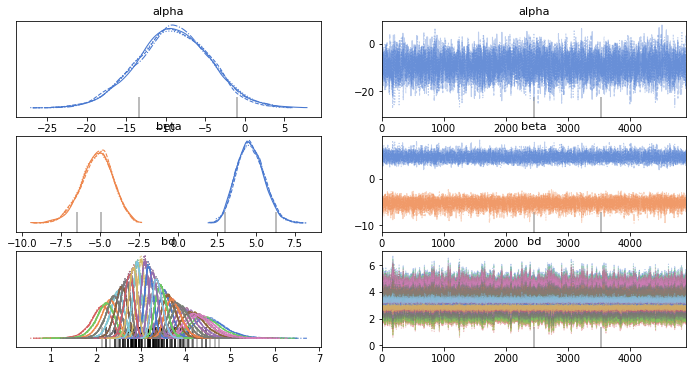

In [55]:
chain_1 = trace_1[100:]
pm.plot_trace(chain_1)
plt.savefig('B04958_05_07.png', dpi=300, figsize=(5.5, 5.5))

In [56]:
#pm.df_summary(chain_1, ['alpha', 'beta'])

/tmp/ipykernel_9138/665887071.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ld_hpd = pm.stats.hdi(chain_1['bd'])[idx]
/tmp/ipykernel_9138/665887071.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('B04958_05_08.png', dpi=300, figsize=(5.5, 5.5))


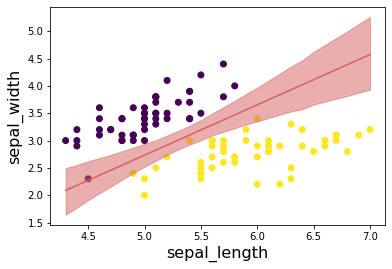

In [57]:
idx = np.argsort(x_1[:,0])
ld = chain_1['bd'].mean(0)[idx]
plt.scatter(x_1[:,0], x_1[:,1], c=y_0)
plt.plot(x_1[:,0][idx], ld, color='r');

ld_hpd = pm.stats.hdi(chain_1['bd'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_08.png', dpi=300, figsize=(5.5, 5.5))

## Correlated variables

/tmp/ipykernel_9138/2716664862.py:4: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('B04958_05_09.png', dpi=300, figsize=(5.5, 5.5))


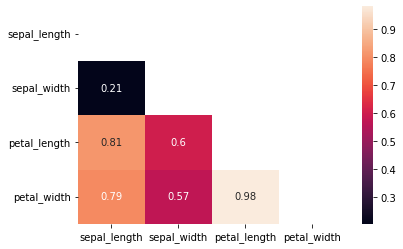

In [58]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True)
plt.savefig('B04958_05_09.png', dpi=300, figsize=(5.5, 5.5))

## Unbalanced Classes

In [59]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:] #df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
#plt.scatter(x_3[:,0], x_3[:,1], c=y_3)

In [60]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic linking function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    ld = pm.Deterministic('ld', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sample(5000)

/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 22 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/tmp/ipykernel_9138/1690056655.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(cadena_3, varnames);
Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


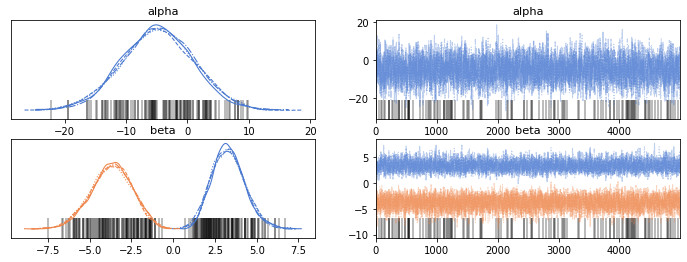

In [61]:
cadena_3 = trace_3[:]
varnames = ['alpha', 'beta']
pm.traceplot(cadena_3, varnames);

In [63]:
pm.summary(cadena_3, varnames)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-4.80,5.89,-16.02,6.22,0.09,0.07,3932.0,4704.0,1.0
beta[0],3.31,1.00,1.47,5.19,0.02,0.01,3447.0,3929.0,1.0
beta[1],-3.70,1.24,-6.00,-1.37,0.02,0.01,3826.0,3756.0,1.0


/tmp/ipykernel_9138/3937890095.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ld_hpd = pm.stats.hdi(trace_3['ld'])[idx]
/tmp/ipykernel_9138/3937890095.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('B04958_05_10.png', dpi=300, figsize=(5.5, 5.5))


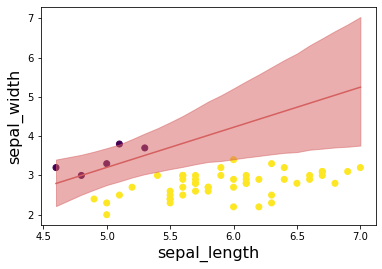

In [64]:
idx = np.argsort(x_3[:,0])
ld = trace_3['ld'].mean(0)[idx]
plt.scatter(x_3[:,0], x_3[:,1], c=y_3)
plt.plot(x_3[:,0][idx], ld, color='r');

ld_hpd = pm.stats.hdi(trace_3['ld'])[idx]
plt.fill_between(x_3[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)
plt.savefig('B04958_05_10.png', dpi=300, figsize=(5.5, 5.5))

## Softmax logistic regression (AKA multinomial regression)

In [65]:
iris = sns.load_dataset("iris")
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1]
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)
#x_s = (x_s - x_s.mean(axis=0))

In [66]:
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=3)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,3))

    mu = alpha + pm.math.dot(x_s, beta)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_s = pm.sample(2000, step, start)

/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/tmp/ipykernel_9138/2198356571.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('B04958_05_12.png', dpi=300, figsize=(5.5, 5.5))


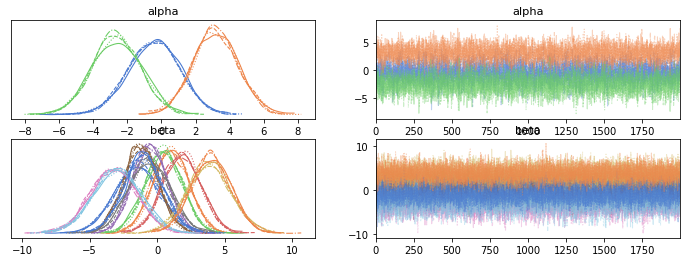

In [67]:
pm.plot_trace(trace_s)
plt.savefig('B04958_05_12.png', dpi=300, figsize=(5.5, 5.5))

In [68]:
pm.summary(trace_s)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.43,1.49,-3.13,2.40,0.02,0.02,5627.0,5648.0,1.0
alpha[1],3.16,1.32,0.73,5.67,0.02,0.01,4651.0,4279.0,1.0
alpha[2],-2.63,1.42,-5.25,0.10,0.02,0.01,5001.0,4177.0,1.0
"beta[0, 0]",-1.49,1.65,-4.59,1.60,0.02,0.02,5385.0,5162.0,1.0
"beta[0, 1]",1.01,1.34,-1.51,3.52,0.02,0.01,4690.0,4853.0,1.0
"beta[0, 2]",0.49,1.36,-2.14,2.99,0.02,0.02,4769.0,4903.0,1.0
"beta[1, 0]",1.82,1.40,-0.86,4.39,0.02,0.01,5154.0,4799.0,1.0
"beta[1, 1]",-0.54,1.27,-2.96,1.77,0.02,0.02,4607.0,4546.0,1.0
"beta[1, 2]",-1.22,1.29,-3.67,1.19,0.02,0.01,4641.0,4391.0,1.0
"beta[2, 0]",-3.21,1.73,-6.30,0.13,0.02,0.02,6097.0,5280.0,1.0


In [ ]:
#pm.autocorrplot(trace_s, varnames=['alpha']);

In [69]:
probs = trace_s['alpha'].mean(axis=0) + np.dot(x_s, trace_s['beta'].mean(axis=0))
y_pred = []
for point in probs:
    y_pred.append(np.exp(point)/np.sum(np.exp(point), axis=0))
np.sum(y_s == np.argmax(y_pred, axis=1))/len(y_s)

0.9733333333333334

In [70]:
with pm.Model() as model_sf:
    alpha = pm.Normal('alpha', mu=0, sd=2, shape=2)
    beta = pm.Normal('beta', mu=0, sd=2, shape=(4,2))
    
    alpha_f = tt.concatenate([[0] , alpha])
    beta_f = tt.concatenate([np.zeros((4,1)) , beta], axis=1)

    mu = alpha_f + pm.math.dot(x_s, beta_f)
    theta = tt.nnet.softmax(mu)

    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_sf = pm.sample(2000, step, start)

/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/tmp/ipykernel_9138/2260660152.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('B04958_05_13.png', dpi=300, figsize=(5.5, 5.5))


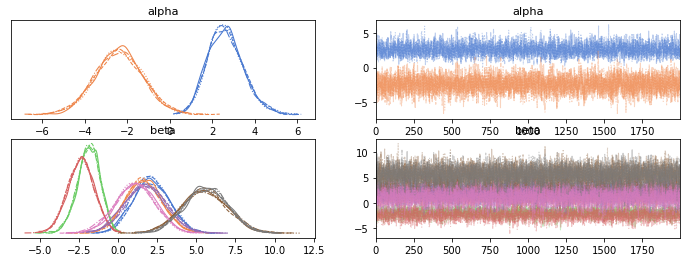

In [71]:
pm.plot_trace(trace_sf)
plt.savefig('B04958_05_13.png', dpi=300, figsize=(5.5, 5.5))

In [72]:
pm.summary(trace_sf)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.64,0.84,1.17,4.31,0.01,1.10e-02,3336.0,3969.0,1.0
alpha[1],-2.39,1.13,-4.54,-0.29,0.02,1.30e-02,3522.0,3718.0,1.0
"beta[0, 0]",2.12,1.15,0.07,4.31,0.02,1.40e-02,3565.0,4037.0,1.0
"beta[0, 1]",1.64,1.18,-0.54,3.87,0.02,1.40e-02,3643.0,4564.0,1.0
"beta[1, 0]",-1.88,0.72,-3.21,-0.51,0.01,8.00e-03,3800.0,4778.0,1.0
"beta[1, 1]",-2.38,0.85,-4.00,-0.79,0.01,9.00e-03,4066.0,4484.0,1.0
"beta[2, 0]",1.77,1.31,-0.73,4.17,0.02,1.50e-02,3984.0,3917.0,1.0
"beta[2, 1]",5.52,1.48,2.81,8.30,0.02,1.50e-02,4673.0,4605.0,1.0
"beta[3, 0]",1.10,1.26,-1.22,3.49,0.02,1.40e-02,3826.0,3769.0,1.0
"beta[3, 1]",5.63,1.37,3.08,8.16,0.02,1.50e-02,4278.0,4577.0,1.0


## Linear discriminat Analysis

In [73]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values

In [74]:
with pm.Model() as model_lda:

    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', 5)
    
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigma, observed=x_0[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigma, observed=x_0[50:])
    
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_lda = pm.sample(5000, step, start)

/home/adegaray/bayesian-lr/.venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mus]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


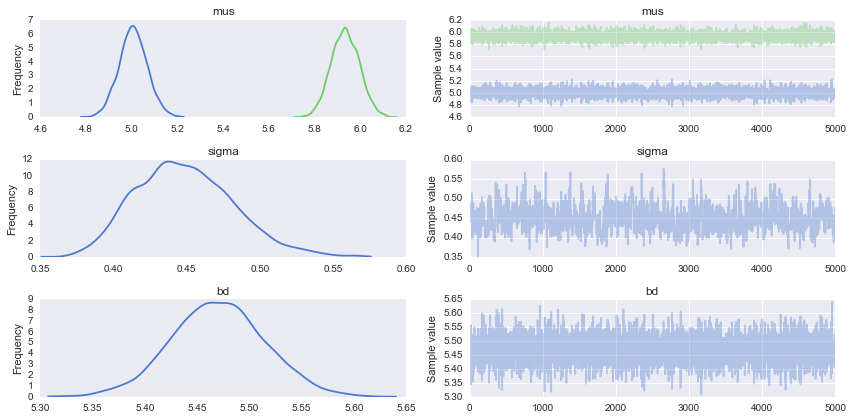

In [ ]:
pm.traceplot(trace_lda)
plt.savefig('B04958_05_14.png', dpi=300, figsize=(5.5, 5.5))

In [ ]:
pm.df_summary(trace_lda)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mus__0,5.01,0.06,8.16e-04,4.88,5.13
mus__1,5.93,0.06,6.28e-04,5.81,6.06
sigma,0.45,0.03,1.52e-03,0.38,0.51
bd,5.47,0.05,5.36e-04,5.38,5.56


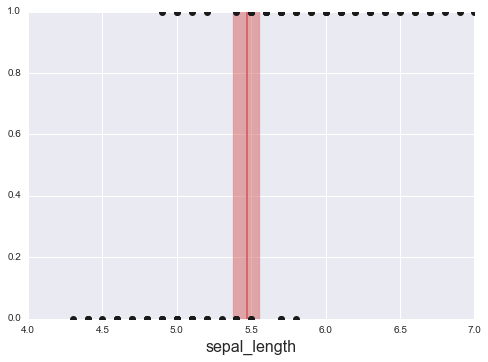

In [ ]:
plt.axvline(trace_lda['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')

plt.xlabel(x_n, fontsize=16)
plt.savefig('B04958_05_15.png', dpi=300, figsize=(5.5, 5.5))

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.5.2
IPython 5.0.0
PyMC3 3.0.rc2
NumPy 1.11.1
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1
Pandas 0.19.0
